In [1]:
import gzip
from collections import defaultdict
import random
from tqdm import tqdm
import numpy as np
import ast
import string
from nltk.stem.porter import *
from sklearn.linear_model import LogisticRegression

## Question 6 {-}

In [2]:
def readJSON(path):
    for l in gzip.open(path, 'rt', encoding="utf8"):
        d = eval(l)
        u = d['userID']
        try:
            g = d['gameID']
        except Exception as e:
            g = None
        yield u,g,d

In [3]:
def parseData(path):
    for l in gzip.open(path, 'rt', encoding="utf8"):
        yield eval(l)
dataset = list(parseData("train_Category.json.gz"))

In [9]:
dataset[0]

{'userID': 'u74382925',
 'genre': 'Adventure',
 'early_access': False,
 'reviewID': 'r75487422',
 'hours': 4.1,
 'text': 'Short Review:\nA good starting chapter for this series, despite the main character being annoying (for now) and a short length. The story is good and actually gets more interesting. Worth the try.\nLong Review:\nBlackwell Legacy is the first on the series of (supposedly) 5 games that talks about the main protagonist, Rosangela Blackwell, as being a so called Medium, and in this first chapter we get to know how her story will start and how she will meet her adventure companion Joey...and really, that\'s really all for for now and that\'s not a bad thing, because in a way this game wants to show how hard her new job is, and that she cannot escape her destiny as a medium.\nMy biggest complain for this chapter, except the short length, it\'s the main protagonist being a "bit" too annoying to be likeable, and most of her dialogues will always be about complaining or just

In [4]:
train = dataset[:165000]
valid = dataset[165000:]

In [5]:
wordCount = defaultdict(int)
totalWords = 0
punct = string.punctuation
stemmer = PorterStemmer()

In [6]:
for d in train:
    t = d['text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        #w = stemmer.stem(w)
        totalWords += 1
        wordCount[w] += 1

In [7]:
counts = [(wordCount[w], w) for w in wordCount]

In [8]:
counts.sort()
counts.reverse()
counts[:10]

[(544597, 'the'),
 (317620, 'and'),
 (305414, 'a'),
 (291882, 'to'),
 (245359, 'game'),
 (227234, 'of'),
 (208417, 'is'),
 (200633, 'you'),
 (195953, 'i'),
 (190966, 'it')]

In [9]:
words = [w[1] for w in counts[:1000]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

## Question 7 {-}

In [10]:
def feature(datum):
    feat = [0]*len(wordSet)
    t = datum['text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if not (w in wordSet): continue
        feat[wordId[w]] += 1
    feat.append(1)
    return feat

In [11]:
X_train = [feature(d) for d in train]
y_train = [d['genreID'] for d in train]
X_valid = [feature(d) for d in valid]
y_valid = [d['genreID'] for d in valid]

In [38]:
len(X_train[0])

1001

In [39]:
X_train[0][:20]

[10, 9, 8, 3, 2, 3, 3, 3, 1, 3, 5, 3, 3, 5, 1, 0, 1, 0, 1, 2]

In [44]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
preds = model.predict(X_valid)
accuracy = sum(1 for a, b in zip(y_valid, preds) if a == b) / len(y_valid)
print("Accuracy is ", accuracy)

Accuracy is  0.6734


## Question 8 {-}

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
size_list = [500 * (n+1) for n in range(6)]
C_list = [0.001 * (10**(n)) for n in range(5)]

In [48]:
print(size_list)
print(C_list)

[500, 1000, 1500, 2000, 2500, 3000]
[0.001, 0.01, 0.1, 1.0, 10.0]


In [53]:
accuracies = []
for C in tqdm(C_list):
    for size in size_list:
        words = [w[1] for w in counts[:size]]
        wordId = dict(zip(words, range(len(words))))
        wordSet = set(words)
        X_train = [feature(d) for d in train]
        X_valid = [feature(d) for d in valid]
        model = LogisticRegression(C=C)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        accuracy = sum(1 for a, b in zip(y_valid, preds) if a == b) / len(y_valid)
        accuracies.append([accuracy, C, size])

100%|██████████| 5/5 [1:33:46<00:00, 1125.34s/it]


In [57]:
accuracies.sort(reverse=True)
accuracies[:15]

[[0.7136, 1.0, 3000],
 [0.7084, 10.0, 3000],
 [0.7074, 0.1, 3000],
 [0.7021, 10.0, 2500],
 [0.7005, 0.1, 2500],
 [0.6981, 1.0, 2000],
 [0.6977, 1.0, 2500],
 [0.6957, 0.1, 2000],
 [0.6954, 10.0, 2000],
 [0.6915, 0.01, 3000],
 [0.6896, 10.0, 1500],
 [0.6891, 1.0, 1500],
 [0.6871, 0.01, 2500],
 [0.6861, 0.1, 1500],
 [0.684, 0.01, 2000]]

***Observations***  
The highest accuracy is obtained by setting dictionary size as 3000 and C as 1.0. The accuracy is 0.7136.  
It appears that the larger the dictionary size is, the better. And C=0.001 should be definitely discarded.  
I will plot the accuracies versus C values for both size=2500 and size=3000.

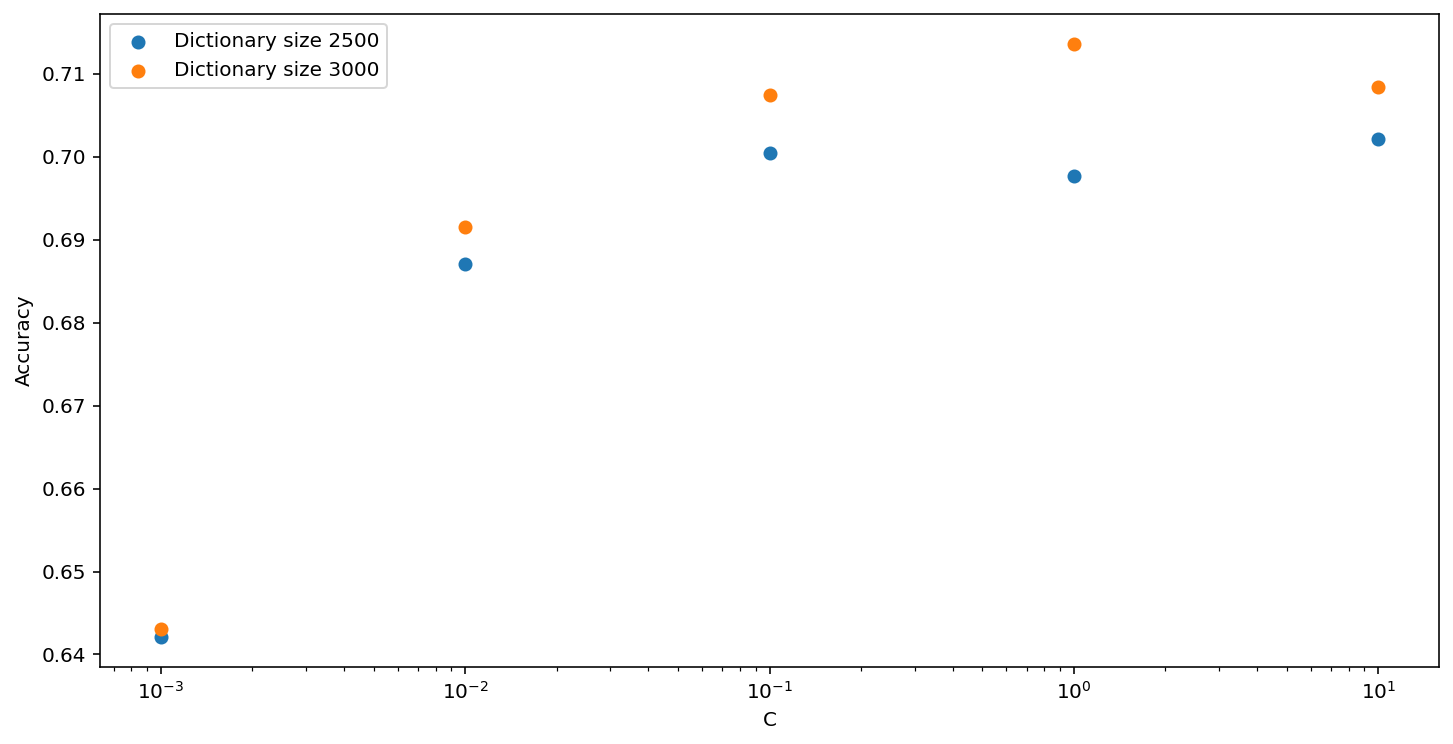

In [63]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.figure(figsize=(12,6))
x1 = [a[1] for a in accuracies if a[2] == 2500]
y1 = [a[0] for a in accuracies if a[2] == 2500]
x2 = [a[1] for a in accuracies if a[2] == 3000]
y2 = [a[0] for a in accuracies if a[2] == 3000]

plt.scatter(x1, y1, label='Dictionary size 2500')
plt.scatter(x2, y2, label='Dictionary size 3000')
plt.xticks(C_list, [str(c) for c in C_list])
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [64]:
# Choose size=3000 and C=1 for prediction on test set
size = 3000
C = 1
words = [w[1] for w in counts[:size]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)
X_train = [feature(d) for d in train]
model = LogisticRegression(C=C)
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
test = list(parseData("test_Category.json.gz"))

In [67]:
test[0]

{'hours': 3.2,
 'early_access': False,
 'date': '2016-03-17',
 'reviewID': 'r23357682',
 'text': "You shouldn't really go into this game looking for a serious experience, this game is a joke and a shallow fun experience and that's great. There is no need to pretend that its any deeper than that. Its nice that the game has a couple of jokes beyond the obvious one built into it and they unfold as you play game giving a bit more longevity. But at the end of the day, its just a fun flash game and even at the price of a dollar I wouldn't buy for myself when I can play games like Rebuild, Sonny and others for free and they offer really deep gaming experiences.\nIf you want to read more about the game in an totally ironic way you can find my review here:\n.",
 'userID': 'u62606497'}

#### Kaggle Username: KelvinSh {-}

In [71]:
predictions = open("predictions_Category.txt", 'w')
predictions.write("userID-reviewID,prediction\n")
for d in test:
    predictions.write(d['userID'] + '-' + d['reviewID'] + "," + str(model.predict([feature(d)])[0]) + "\n")

predictions.close()

##### Further parameters tuning (especially on dictionary size) {-}

In [13]:
size_list = [2800 + 200 * n for n in range(12)]
C_list = [0.1, 1, 10]

In [14]:
print(size_list)

[2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000]


In [15]:
accuracies = []
for C in C_list:
    for size in tqdm(size_list):
        words = [w[1] for w in counts[:size]]
        wordId = dict(zip(words, range(len(words))))
        wordSet = set(words)
        X_train = [feature(d) for d in train]
        X_valid = [feature(d) for d in valid]
        model = LogisticRegression(C=C)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        accuracy = sum(1 for a, b in zip(y_valid, preds) if a == b) / len(y_valid)
        accuracies.append([accuracy, C, size])

  8%|███▎                                   | 1/12 [28:12<5:10:19, 1692.69s/it]Exception ignored in: <generator object tqdm.__iter__ at 0x000002781A104EB8>
Traceback (most recent call last):
  File "c:\program files\python36\lib\site-packages\tqdm\std.py", line 1221, in __iter__
    self.last_print_n = last_print_n
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
%store accuracies